## **Installing and Importing Required Packages**

### **Installing Required Packages**

In [ ]:
!pip install lightning
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers
!pip install optuna-integration
!pip install -U 'wandb>=0.12.10'

### **Importing Required Packages**

In [2]:
import os
import random
from os import path
import wandb
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt # this is used for the plot the graph
import seaborn as sns # used for plot interactive graph. I like it most for plot
import torch
from torch import cuda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics.classification import MulticlassPrecision,MulticlassF1Score,MulticlassRecall,MulticlassAccuracy

import torchvision.transforms as transforms
from torchvision.models import resnet152#resnet50 #resnet34,resnet101

from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoModel, AutoTokenizer
import lightning as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torchvision.models import resnet152, ResNet152_Weights

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.samplers import TPESampler

wandb_logger = WandbLogger(log_model="all",project="Multimodal",name='Multi Modal Classification')

## **Loading Data and Preprocessing**

### **Loading Data**

>>> SEEDED <<<
     image_name                                     text_corrected  \
0   image_1.jpg  LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...   
1  image_2.jpeg  The best of #10 YearChallenge! Completed in le...   
2   image_3.JPG  Sam Thorne @Strippin ( Follow Follow Saw every...   
3   image_4.png              10 Year Challenge - Sweet Dee Edition   
4   image_5.png  10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...   

   not_offensive  slight_offensive  very_offensive  
0              1                 0               0  
1              1                 0               0  
2              1                 0               0  
3              0                 1               0  
4              0                 1               0  
Class Counts:
class_label
not_offensive       5305
slight_offensive    1466
very_offensive       221
Name: count, dtype: int64


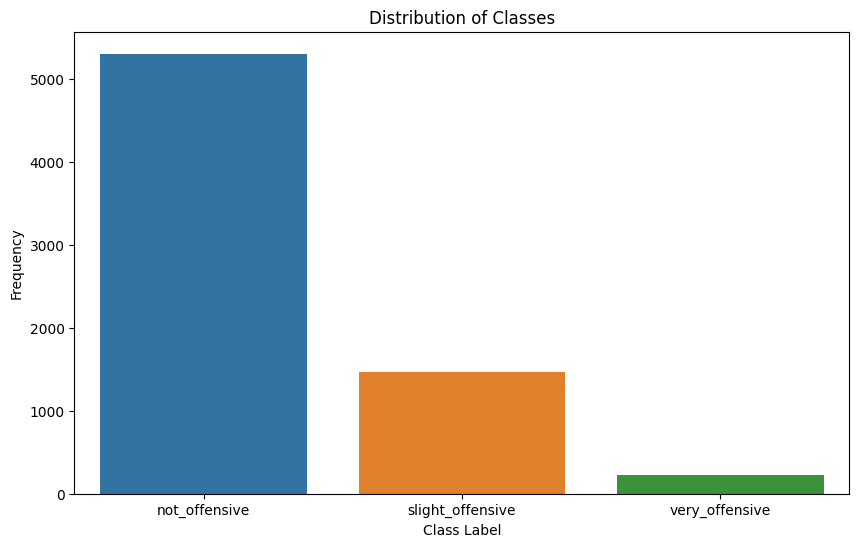

In [3]:
def set_seed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(">>> SEEDED <<<")

set_seed(42)

df = pd.read_csv('/kaggle/input/merge-meme/Img', index_col=0)
print(df.head())

# Data Analysis: Classwise Count Plot
class_columns = ['not_offensive', 'slight_offensive', 'very_offensive']
df['class_label'] = df[class_columns].idxmax(axis=1)

# Calculate and print class counts
class_counts = df['class_label'].value_counts()
print("Class Counts:")
print(class_counts)

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(x='class_label', data=df, order=class_counts.index)  # This ensures the bars are sorted by count
plt.title('Distribution of Classes')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()

In [4]:
df = df.sample(frac=1, random_state=42)
#df.head()
N = len(df)
TRAIN_SIZE = int(N*0.8)
train_df = df.iloc[:TRAIN_SIZE]
test_df = df.iloc[TRAIN_SIZE:]
len(train_df),len(test_df)

count_column1 = df['not_offensive'].value_counts()
print("Counts for Column1:")
print(count_column1)
count_column2 = df['slight_offensive'].value_counts()
print("Counts for Column2:")
print(count_column2)
count_column3 = df['very_offensive'].value_counts()
print("Counts for Column3:")
print(count_column3)

Counts for Column1:
not_offensive
1    5305
0    1687
Name: count, dtype: int64
Counts for Column2:
slight_offensive
0    5526
1    1466
Name: count, dtype: int64
Counts for Column3:
very_offensive
0    6771
1     221
Name: count, dtype: int64


In [5]:
w1, w2, w3 = 2713/(2713+2592+1703), 2592/(2713+2592+1703), 1703/(2713+2592+1703)

IMAGES_URL1 = '/kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images'
IMAGE_COLUMN = 0
TEXT_COLUMN = 1
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
TEXT_MAX_LENGTH = 128

# Define the path
path = '/kaggle/input/memotion-dataset-7k/memotion_dataset_7k/images'
# Check if the directory exists
if os.path.exists(path):
    print("Directory exists!")
else:
    print("Directory does not exist. Please verify the path.")

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Directory exists!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
from torchvision import transforms

class MMDataSet(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        self.transform = transform
        self.df = df.copy()
        self.image_folder1 = IMAGES_URL1
        self.tokenizer = tokenizer
        self.length = len(df)
        self.label_mapping = {'not_offensive': 0, 'slight_offensive': 1, 'very_offensive': 2}

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        attempts = 0
        max_attempts = 5
        while attempts < max_attempts:
            try:
                row = self.df.iloc[idx]
                label = row['class_label']
                y = torch.tensor(self.label_mapping[label], dtype=torch.long)

                img_name = row['file_name']
                img_path = os.path.join(self.image_folder1, img_name)
                image = self.load_image(img_path)

                text = str(row['text']).lower()  # Convert to string to handle non-string types
                out = self.tokenizer(
                    text=text,
                    max_length=TEXT_MAX_LENGTH,
                    padding='max_length',
                    truncation=True,
                    return_tensors="pt"
                )
                ids = out['input_ids'].squeeze()
                mask = out['attention_mask'].squeeze()
                token_type_ids = out.get("token_type_ids", torch.tensor([])).squeeze()

                return (image, ids, mask, token_type_ids), y
            except Exception as e:
                print(f"Error at index {idx}: {e}")
                idx = (idx + 1) % self.length  # Cycle through indices safely
                attempts += 1
        raise RuntimeError("Failed to retrieve a valid data item after multiple attempts.")

    def load_image(self, file_path):
        try:
            with Image.open(file_path) as img:
                if img.mode == 'P':  # Checks if the image is in palette mode
                    img = img.convert('RGBA').convert('RGB')
                else:
                    img = img.convert('RGB')
                if self.transform:
                    img = self.transform(img)
            return img
        except IOError as e:
            print(f"Cannot load image at {file_path}: {e}")
            return None

# Assuming `train_df`, `test_df`, `tokenizer`, `transform`, and `IMAGES_URL1` are defined elsewhere
train_dataset = MMDataSet(train_df, tokenizer, transform)
test_dataset = MMDataSet(test_df, tokenizer, transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2)

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import torch.nn as nn

class MultiModel(pl.LightningModule):
    def __init__(self, learning_rate, cell_count, dropout):
        super(MultiModel, self).__init__()
        self.learning_rate = learning_rate
        self.cell_count = cell_count
        self.dropout_rate = dropout

        # Metrics
        self.accuracy = MulticlassAccuracy(num_classes=3, average=None)
        self.precision = MulticlassPrecision(num_classes=3, average=None)
        self.f1score = MulticlassF1Score(num_classes=3, average=None)
        self.recall = MulticlassRecall(num_classes=3, average=None)
        self.criterion = nn.CrossEntropyLoss()

        # ResNet
        self.resnet = resnet152(weights=ResNet152_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 512)  # Modify the final layer to output 512 features

        # BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False

        # Additional layers to process ResNet and BERT outputs
        self.fc_img = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )
        self.fc_txt = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_rate),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        image, ids, mask, token_type_ids = x

        # Process image through ResNet
        img_features = self.resnet(image)
        img_features = self.fc_img(img_features)

        # Process text through BERT
        _, txt_features = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        txt_features = self.fc_txt(txt_features)

        # Combine features
        combined_features = torch.cat([img_features, txt_features], dim=1)
        output = self.classifier(combined_features)

        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()

        self.log('train/loss', loss, on_step=True, prog_bar=True, on_epoch=True)
        self.log('train/acc', acc, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = CosineAnnealingLR(optimizer, T_max=50)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [9]:
# Objective function definition
def objective(trial: optuna.trial.Trial) -> float:
    learning_rate = 0.002
    cell_count = 10
    dropout = 0.3
    print(f'Training with learning rate: {learning_rate}, cell count: {cell_count}, and dropout: {dropout}')
    model = MultiModel(learning_rate=learning_rate, cell_count=cell_count, dropout=dropout)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    callbacks = model.configure_callbacks()

    trainer = pl.Trainer(max_epochs=60, devices=1, accelerator="auto", callbacks=callbacks)
    trainer.fit(model, train_dataloader, test_dataloader)

    return trainer.callback_metrics["val_prec"].item()

In [10]:
# Optuna study creation and optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)
print("Best trial:")
print(study.best_trial.params)
print("Best value:")
print(study.best_trial.value)

[I 2024-05-08 09:47:46,661] A new study created in memory with name: no-name-c05112af-3f51-4a99-9f9e-275895196a63


Training with learning rate: 0.002, cell count: 10, and dropout: 0.3


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 152MB/s]  


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
2024-05-08 09:47:55.939968: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 09:47:55.940069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 09:47:56.067721: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOC

Error at index 3601: 'file_name'
Error at index 3602: 'file_name'
Error at index 3603: 'file_name'Error at index 26: 'file_name'



Training: |          | 0/? [00:00<?, ?it/s]

Error at index 3604: 'file_name'Error at index 27: 'file_name'

Error at index 3605: 'file_name'Error at index 28: 'file_name'

Error at index 29: 'file_name'
Error at index 30: 'file_name'Error at index 1181: 'file_name'

Error at index 1182: 'file_name'
Error at index 1183: 'file_name'
Error at index 1184: 'file_name'Error at index 3110: 'file_name'
Error at index 1185: 'file_name'

Error at index 2651: 'file_name'
Error at index 2652: 'file_name'Error at index 2653: 'file_name'
Error at index 3111: 'file_name'
Error at index 3112: 'file_name'
Error at index 2654: 'file_name'

Error at index 3113: 'file_name'
Error at index 2655: 'file_name'
Error at index 3114: 'file_name'


[W 2024-05-08 09:48:05,270] Trial 0 failed with parameters: {} because of the following error: RuntimeError('Caught RuntimeError in DataLoader worker process 0.\nOriginal Traceback (most recent call last):\n  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop\n    data = fetcher.fetch(index)\n  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch\n    data = [self.dataset[idx] for idx in possibly_batched_index]\n  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>\n    data = [self.dataset[idx] for idx in possibly_batched_index]\n  File "/tmp/ipykernel_34/1127707294.py", line 45, in __getitem__\n    raise RuntimeError("Failed to retrieve a valid data item after multiple attempts.")\nRuntimeError: Failed to retrieve a valid data item after multiple attempts.\n').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/si

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_34/1127707294.py", line 45, in __getitem__
    raise RuntimeError("Failed to retrieve a valid data item after multiple attempts.")
RuntimeError: Failed to retrieve a valid data item after multiple attempts.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_training_results(trainer):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(trainer.callback_metrics['train/loss'], label='Training Loss')
    plt.plot(trainer.callback_metrics['val/val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(trainer.callback_metrics['train_acc'], label='Training Accuracy')
    plt.plot(trainer.callback_metrics['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.show()

    # Compute confusion matrix for the last epoch
    last_batch_predictions = torch.argmax(trainer.callback_metrics['val/y_hat'], dim=1)
    conf_matrix = confusion_matrix(trainer.callback_metrics['val/y'], last_batch_predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call this function after your training process
plot_training_results(trainer)